# 📷 CBIR (Content-Based Image Retrieval)

CBIR은 **Content-Based Image Retrieval**의 약자로,
이미지 자체의 **시각적 내용(색상, 모양, 질감 등)**을 기반으로
**유사한 이미지를 검색**하는 기술

---

## ✅ 주요 개념

- **쿼리 이미지**: 사용자가 검색하고자 하는 기준 이미지
- **특징 추출**: 이미지에서 색상, 모양, 질감 등 시각적 특성을 벡터로 표현
- **유사도 계산**: 쿼리 벡터와 데이터베이스 벡터들 간 거리(L2, 코사인 등)를 비교
- **결과 반환**: 가장 가까운(=유사한) 이미지들을 반환

---

## 🔁 CBIR 동작 흐름

1. 입력 이미지 (Query Image)
2. 이미지 특징 벡터 추출 (CNN, HOG, etc.)
3. DB 내 모든 이미지들과 특징 벡터 비교
4. 거리 기반으로 Top-k 유사 이미지 반환

---

## 🧠 특징 추출 방식 예시

- **전통적 방법**: 색 히스토그램, SIFT, HOG
- **딥러닝 기반**: ResNet, VGG, CLIP 등 CNN 모델의 중간 출력 사용

---

## 📚 활용 분야

- 쇼핑몰 유사 상품 검색
- 의료 영상 유사 사례 검색
- 디지털 미술관 작품 추천
- 얼굴, 지문 등의 생체 인식

In [1]:
import requests
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms
import torch
import torchvision.models as models
import numpy as np
import faiss # faiss는 Facebook이 만든 고속 벡터 유사도 검색 라이브러리
import matplotlib.pyplot as plt

In [3]:
# -------------------------------
# 1. 사전 준비
# -------------------------------
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ResNet50 모델 로드
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
# 마지막 출력층을 자른 것. (새 이미지가 입력될 때, 나오는 출력값을 특징 값으로 사용하기 위해)
model.eval().to(device)


/opt/anaconda3/envs/BEstudy-Yuseok/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/BEstudy-Yuseok/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/bu11/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [10]:
# -------------------------------
# 2. 이미지 URL 리스트
# -------------------------------
image_urls = [
    "https://images.unsplash.com/photo-1537151625747-768eb6cf92b2?q=80&w=2568&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",  # 강아지1
    "https://images.unsplash.com/photo-1596492784531-6e6eb5ea9993?q=80&w=3687&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",  # 강아지2
    "https://images.unsplash.com/photo-1491604612772-6853927639ef?q=80&w=3687&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",  # 강아지3
    "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?q=80&w=3486&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",  # 고양이1
    "https://images.unsplash.com/photo-1561948955-570b270e7c36?q=80&w=3035&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",  # 고양이2
]

query_url = "https://images.unsplash.com/photo-1543466835-00a7907e9de1?q=80&w=3474&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

In [11]:
# -------------------------------
# 3. 이미지 불러오기 및 특징 추출
# -------------------------------
def load_image_from_url(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

def extract_feature(img):
    img_tensor = transform(img).unsqueeze(0).to(device)
    # unsqueeze(0): 0번째 차원을 추가 (배치 차원)
    # torch.Size([3, 224, 224]) → torch.Size([1, 3, 224, 224])
    with torch.no_grad():
    # 해당 블록 안에서는 그래디언트(gradient)를 계산하지 마라
    # 추론하거나 메모리 절약할 때 사용
        feat = model(img_tensor).squeeze().cpu().numpy()
        # squeeze(): 크기가 1인 차원 모두 제거
        # [1, 2048, 1, 1] → [2048]
    return feat / np.linalg.norm(feat) # 정규화

# DB 이미지들 처리
db_images = [load_image_from_url(url) for url in image_urls]
db_features = np.array([extract_feature(img) for img in db_images]).astype("float32")

# 쿼리 이미지 처리
query_image = load_image_from_url(query_url)
query_feature = extract_feature(query_image).astype("float32").reshape(1, -1)
# reshape(1, -1): 1행, 열은 알아서
# (2048,)  → (1, 2048)

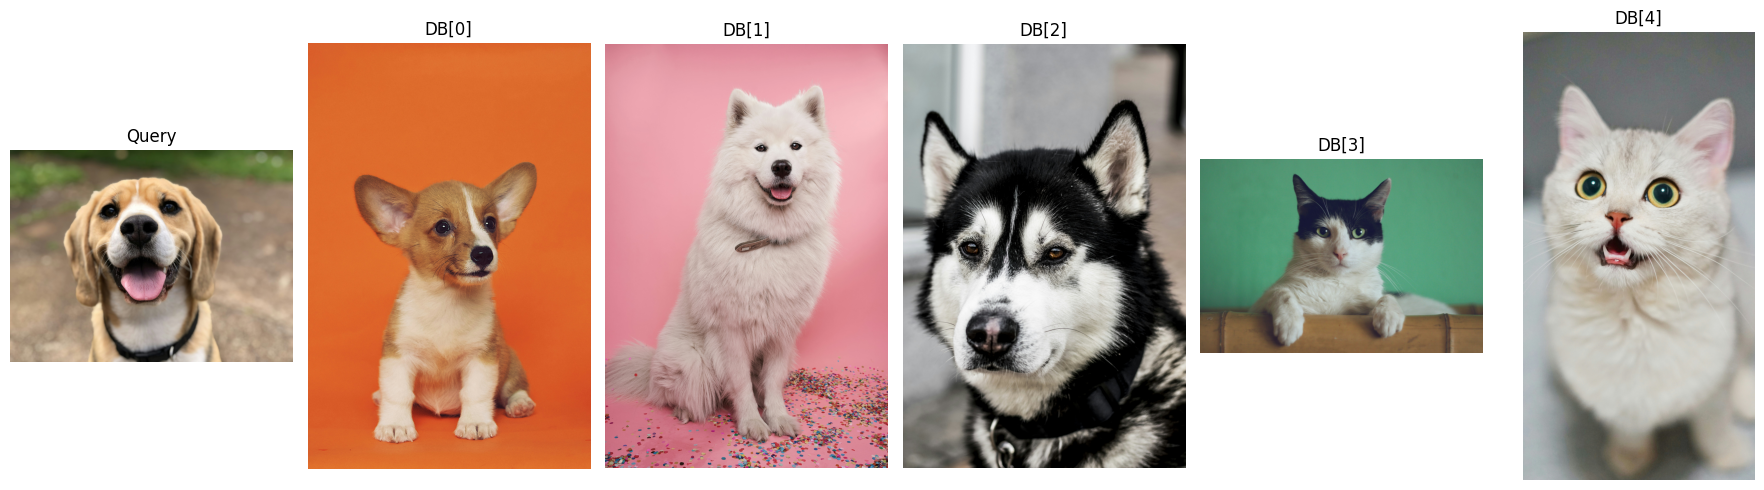

In [12]:
# 이미지 출력 함수
def show_all_images(query_img, db_imgs, titles=None):
    plt.figure(figsize=(18, 5))

    # 쿼리 이미지
    plt.subplot(1, len(db_imgs) + 1, 1)
    plt.imshow(query_img)
    plt.title("Query")
    plt.axis("off")

    # DB 이미지들
    for i, img in enumerate(db_imgs):
        plt.subplot(1, len(db_imgs) + 1, i + 2)
        plt.imshow(img)
        if titles:
            plt.title(titles[i])
        else:
            plt.title(f"DB[{i}]")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# 호출
show_all_images(query_image, db_images)

In [13]:
# -------------------------------
# 4. 유사도 검색 (faiss)
# -------------------------------
index = faiss.IndexFlatL2(db_features.shape[1]) # db_features = (5,2048)
# 현재는 2048의 크기만큼 구조만 생성됌
# L2 거리 기반의 유사도 검색
# faiss는 Facebook이 만든 고속 벡터 유사도 검색 라이브러리
index.add(db_features)
# 실제 특징 벡터들을 삽입
D, I = index.search(query_feature, k=3)  # top-3 유사 이미지 검색
# D: 유사도 거리 값
# I: 유사 벡터 인덱스

Query 이미지와 유사한 이미지 인덱스: [0 3 4]


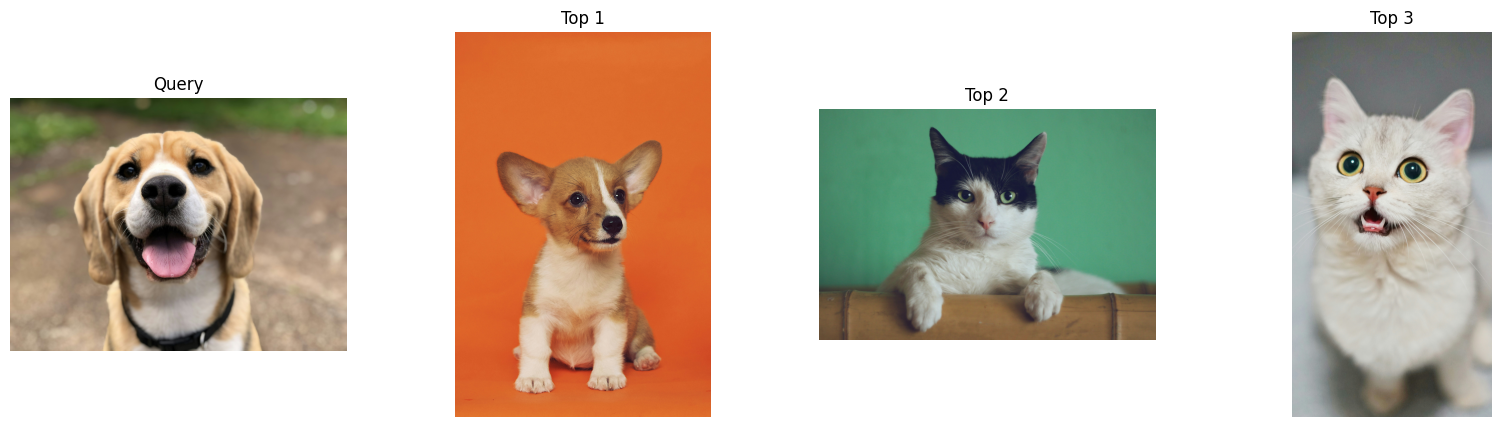

In [14]:
# -------------------------------
# 5. 결과 시각화
# -------------------------------
def show_images(images, titles, rows=1):
    plt.figure(figsize=(5 * len(images), 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, len(images), i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    plt.show()

# 시각화
top_k_indices = I[0]
top_k_images = [db_images[i] for i in top_k_indices]

print("Query 이미지와 유사한 이미지 인덱스:", top_k_indices)
show_images([query_image] + top_k_images, ["Query"] + [f"Top {i+1}" for i in range(len(top_k_images))])